In [99]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.21.5
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


* 添加高空层次, 特别是逆温的判别
* 自定义损失函数

In [96]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

In [157]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/extend/fog_dataset_extend.hdf"
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')

# df_train.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_valid.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_test.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]

# x_columns = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_linear']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_linear']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_linear']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)


['/test', '/train', '/valid']
(63311, 15)
(63311,)


In [158]:
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
valid_x_scaled = scaler.fit_transform(valid_x)
test_x_scaled  = scaler.fit_transform(test_x)

train_x_scaled[:,0:3] = train_x[:,0:3]
train_x_scaled[:,-5:-1] = train_x[:,-5:-1]
valid_x_scaled[:,0:3]   = valid_x[:,0:3]
valid_x_scaled[:,-5:-1] = valid_x[:,-5:-1]
test_x_scaled[:,0:3]    = test_x[:,0:3]
test_x_scaled[:,-5:-1]  = test_x[:,-5:-1]

In [159]:
print(np.max(train_x_scaled[:,-5]), np.min(train_x_scaled[:,-5]))

0.9999855506507186 -0.9999994220246925


In [160]:
train_x[:,0:3]

array([[ 7.22698975, -8.03289795, -0.8059082 ],
       [ 2.08071899, -3.93084717, -1.85012817],
       [ 3.546875  , -3.62072754, -0.07385254],
       ...,
       [ 2.21875   , -2.43707275, -0.21832275],
       [ 2.65200806, -4.80477905, -2.152771  ],
       [ 3.86972046, -5.04449463, -1.17477417]])

In [161]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu',
                       input_shape=train_x_scaled.shape[1:]),                 
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1),
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="mean_squared_error", optimizer="sgd")

In [162]:
train_x_scaled.shape[1:]

(15,)

In [163]:
model.layers

In [90]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 30)                480       
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 186       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 7         
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]

In [172]:
# H:/github/python/seafog/
logdir = './callbacks_reg'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "sea_fog_reg_model.h5")

model_callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    # keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4),
    ]
history = model.fit(train_x_scaled, train_y, epochs=50,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = model_callbacks)

Epoch 1/50
1979/1979 [==============================] - 5s 2ms/step - loss: 0.1231 - val_loss: 0.2532
Epoch 2/50
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1230 - val_loss: 0.2580
Epoch 3/50
1979/1979 [==============================] - 5s 2ms/step - loss: 0.1225 - val_loss: 0.2539
Epoch 4/50
1979/1979 [==============================] - 6s 3ms/step - loss: 0.1224 - val_loss: 0.2673
Epoch 5/50
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1219 - val_loss: 0.2659
Epoch 6/50
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1214 - val_loss: 0.2611
Epoch 7/50
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1215 - val_loss: 0.2616
Epoch 8/50
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1212 - val_loss: 0.2533
Epoch 9/50
1979/1979 [==============================] - 4s 2ms/step - loss: 0.1209 - val_loss: 0.2594
Epoch 10/50
1979/1979 [==============================] - 4s 2ms/step - loss: 0.120

In [ ]:
type(history)

In [ ]:
history.history

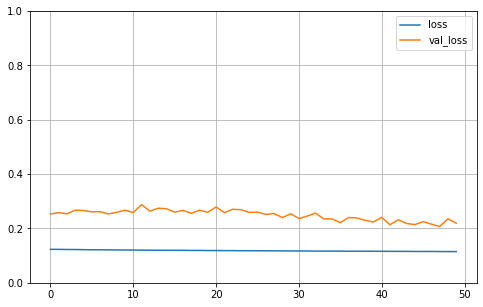

In [173]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [174]:
model.evaluate(test_x_scaled, test_y, verbose=0)

0.304381400346756

* 默认方法MSE 在0.36左右，关键因素是温度和日期
* 添加t-td 等函数后，MSE 在0.3

In [175]:
predictions = model(test_x_scaled).numpy()
predictions

array([[0.24852812],
       [0.44387925],
       [0.38093388],
       ...,
       [2.2665093 ],
       [2.4807446 ],
       [2.3409476 ]], dtype=float32)

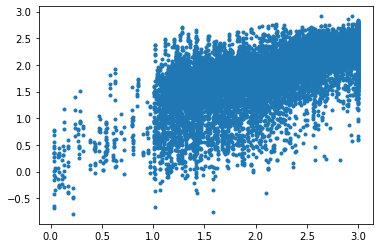

In [176]:
plt.plot(test_y, predictions,'.')
plt.show()

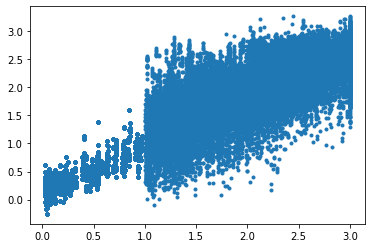

In [177]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.')
plt.show()

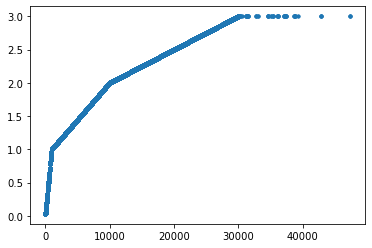

In [17]:
plt.plot(df_train['station_vis'].values,train_y,'.')
plt.show()

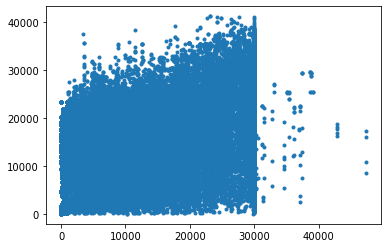

In [55]:
plt.plot(df_train['station_vis'].values,df_train['visi'],'.')
plt.show()

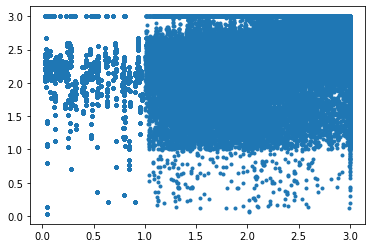

1.2369055392943231


In [100]:
plt.plot(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis)))

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 